# Recommendations with IBM

In this notebook, we are building a recommender for the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [70]:
### Let's get the party started 
### importing the necessary libraries and reading in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [71]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Firstly, we will look into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [86]:
df_by_user = df.groupby('email')
df_n_article = df_by_user.count()['title']# for unqiue: df_by_user.agg({"article_id": "nunique"})

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: title, dtype: float64

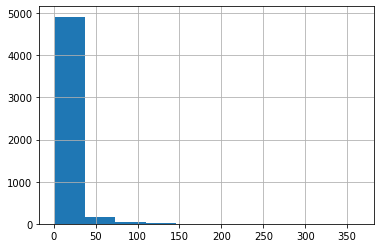

In [87]:
df_n_article.hist()
df_n_article.describe()

In [88]:
median_val = 3.0
print('50% of individuals interact with {} articles or fewer.'.format(median_val))
max_views_by_user = 364
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [76]:
# Find and explore duplicate articles
### with duplicated ID; w/o duplicated ID
df_content.shape[0], df_content.article_id.nunique()

(1056, 1051)

In [77]:
# Find and explore duplicate articles
df_content_id = df_content.article_id.value_counts()
df_content_id[df_content_id > 1]

221    2
232    2
577    2
398    2
50     2
Name: article_id, dtype: int64

In [78]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)
df_content.shape

(1051, 5)

`3.` Some insights:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [79]:
type(df.article_id.nunique())

int

In [80]:
unique_articles = df.article_id.nunique()
print('There are {} unique articles that have at least one interaction.'.format(unique_articles))
total_articles =  df_content.article_id.nunique()
print('There are {} unique articles on the IBM platform.'.format(total_articles))
unique_users = df.email.nunique(dropna=True)
print('There are {} unique users.'.format(unique_users))
user_article_interactions = df.shape[0] # for unique: drop_duplicates(subset=['article_id','email'])
print('There are {} user-article interactions.'.format(user_article_interactions))

There are 714 unique articles that have at least one interaction.
There are 1051 unique articles on the IBM platform.
There are 5148 unique users.
There are 45993 user-article interactions.


`4.` What is the most viewed **article_id**? How often it was viewed?  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user.

In [95]:
# map the user email to a user_id column and remove the email column
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [96]:
df_views = df.groupby('article_id').count()['user_id']

In [97]:
most_viewed_article_id = str(df_views.idxmax())
print('The most viewed article in the dataset is ID {}'.format(most_viewed_article_id))
max_views = df_views.max()
print('The most viewed article in the dataset was viewed {} times'.format(max_views))

The most viewed article in the dataset is ID 1429.0
The most viewed article in the dataset was viewed 937 times


In [98]:
# Test the dictionary against the solution

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

The popularity of an article is based on how often an article was interacted with.

`1.` Create a function to return the **n** top articles ordered with most interactions as the top.

In [127]:
df_sort.head(10).index

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64', name='article_id')

In [124]:
list(df[df['article_id'].isin(df_sort.head(10).index)].drop_duplicates('article_id')['title'])

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [381]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_sort = df.groupby('article_id').count()['user_id'].sort_values(ascending = False)
    top_articles = df[df['article_id'].isin(df_sort.head(n).index)].drop_duplicates('article_id')['title']
    
    return list(top_articles) # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    df_sort = df.groupby('article_id').count()['user_id'].sort_values(ascending = False)
    top_articles = df_sort.head(10).index
    
    return [str(i) for i in top_articles] # Return the top article ids

In [382]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [383]:
# Test the function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 



In [150]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id']).count().unstack()
    user_item = user_item.fillna(0)
    
    ### returning 1's if there is interaction
    def back2one(t):    
        if t > 0:
            return 1
    user_item = user_item.applymap(back2one)
    
    ### returning 0's if there is no interaction
    user_item.fillna(0, inplace = True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [151]:
## Use the tests to make sure the basic structure of the matrix matches what is expected by the solution.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Create a function which takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it makes sense to compute similarity as the dot product of two users. 

In [328]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = np.dot(user_item.loc[user_id], user_item.T)

    # sort by similarity; create list of just the ids
    most_similar_users = list(similarity.argsort())

    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [329]:
# Do a spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [2574, 2910, 2915, 2917, 2919, 2920, 2921, 2922, 2926, 2927]
The 5 most similar users to user 3933 are: [2574, 2944, 2946, 2947, 2949]
The 3 most similar users to user 46 are: [2574, 2804, 2805]


`3.` Now that we have a function that provides the most similar users to each user, we want to use these users to find articles we can recommend.  The functions below return the articles we would recommend to each user. 

In [372]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df.article_id.isin(article_ids)].drop_duplicates('article_id')['title']
    
    return list(article_names) # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    articles = user_item.loc[user_id]
    articles = articles[articles == 1]
    article_ids = articles.reset_index(0).index
    article_names = get_article_names(article_ids)
    return [str(ids) for ids in article_ids], list(article_names) # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    article_seen_ids, _ = get_user_articles(user_id)
    article_ids_list = []
    for u in similar_users:
        article_ids, _ = get_user_articles(u)
        article_ids = [ids for ids in article_ids if ids not in article_seen_ids]
        if article_ids:
            article_ids_list.extend(article_ids)
            article_ids_list = list(set(article_ids_list)) # remove duplicates
        if len(article_ids_list) >= m:
            recs = article_ids_list[:m]
            break
            
    return recs # return your recommendations for this user_id    

In [346]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['ibm watson facebook posts for 2015',
 'city population by sex, city and city type',
 'uci: white wine quality',
 'model bike sharing data with spss',
 'intentional homicide, number and rate per 100,000 population, by country',
 'fortune 100 companies',
 'customer demographics and sales',
 'uci: red wine quality',
 'machine learning exercises in python, part 1',
 'airbnb data for analytics: barcelona listings',
 'foundational methodology for data science',
 'generalization in deep learning',
 'predict chronic kidney disease using spss modeler flows',
 'from scikit-learn model to cloud with wml client']

In [332]:
# Test the functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [373]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame({
        'neighbor_id': [i + 1 for i in range(df.user_id.nunique())],
        'similarity': np.dot(user_item.loc[user_id], user_item.T),
        'num_interactions':user_item.sum(axis=1)})  
    
    neighbors_df.drop([user_id], inplace = True) # remove the current user_id
    
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], 
                             ascending= [False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    article_seen_ids, _ = get_user_articles(user_id)
    article_ids_list = []
    for u in neighbors_df.index:
        article_ids, _ = get_user_articles(u)
        ### filter out those seen and recommended articles
        article_ids = [ids for ids in article_ids if ids not in article_seen_ids + article_ids_list]
        if article_ids:
            ### find these articles in df
            df_filter = df[df.article_id.isin(article_ids)] 
            ### get count of interaction and sort
            df_count = df_filter.groupby('article_id').count()['user_id'].sort_values(ascending = False)
            ### get index article_ids
            article_ids = [str(i) for i in df_count.index]
            article_ids_list.extend(article_ids)
        if len(article_ids_list) >= m:
            recs = article_ids_list[:m]
            rec_names = get_article_names(recs)
            break   
    
    return recs, rec_names

In [374]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1431.0', '1427.0', '1293.0', '1170.0', '1436.0', '43.0', '1185.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'welcome to pixiedust', 'finding optimal locations of new store using decision optimization', 'deep learning with tensorflow course by big data university']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [369]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0,0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10,0]# Find the 11th most similar user to user 131

In [370]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would we be able to use to make recommendations?  What might be the better way to make recommendations?

**With a cold start problem, we can not use User-User Based Collaborative Filtering due to lack of user-user information. The Rank-Based Recommendations can come to use since it does not rely on user information at all. A better way may be that allowing new users pick a few topic words and then making recommendation based on that.**

`7.` What would our recommendations be for this new user '0.0'?  As a new user, they have no observed articles.

In [386]:
new_user = '0.0'

# Provide a list of the top 10 article ids we would give to 

new_user_recs = get_top_article_ids(10)

In [387]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Create the function for a content based recommender. 



In [406]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [489]:
def make_content_recs(df_content, query_text, threshold=0.0, top=10):
    '''
    INPUT:
    df_content - (pandas dataframe) the dataframe mentioned above
    query_text - (string) the string of the user input
    threshold - (float) the lower threshold of the cosine similarity
    top - (int) the number of recommneded items
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id    
    '''
    ### combine the text columns
    corpus = list(df_content.apply(\
        lambda x:'%s %s %s' %(x['doc_body'],x['doc_description'], x['doc_full_name']), axis=1))
    tfidf = TfidfVectorizer(ngram_range=(1,2), \ # one word or two words
                            token_pattern=r'(?u)\b[A-Za-z\']{2,}\b', \ # exclude numbers and single char
                            stop_words = 'english', max_features = 500, max_df=0.9)

    corpus_tfidf = tfidf.fit_transform(corpus)
    text_tfidf = tfidf.transform([query_text])
    
    ### calculate cosine similarity
    sim = cosine_similarity(corpus_tfidf, text_tfidf)
    sim_idx = (sim >= threshold).nonzero()[0] # remove zeros
    result = pd.DataFrame({'similarity':sim[sim_idx].reshape(-1,)},
                          index = sim_idx)
    
    ### sort and recommend top ones
    result_idx = result.sort_values(by=['similarity'], ascending=False).head(top).index
    recs = list(df_content.loc[result_idx].article_id)
    
    return recs

`2.` A summary of how the content-based recommendation system.

** The content-based recommendation system utilizes all the text information in df_content. The new user can pick an article he/she is interested. Based on the title of that article, we can calculate the cosine similarity between that title and the text corpus after tfidf transformation. Recommendations are made based on highest similarities. A possible improvement is to include the current hot articles with most interactions. Another possible improvement is to use tranfer learning and calculate similarity based on Doc2Vec.**

`3.` Use the content-recommendation system to make recommendations for the below scenarios.

In [492]:
# make recommendations for a brand new user
get_top_articles(10)

['healthcare python streaming application demo',
 'use deep learning for image classification',
 'apache spark lab, part 1: basic concepts',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'finding optimal locations of new store using decision optimization']

In [493]:
# make a recommendations for a user who only has interacted with article id '1427.0'
query_text = df.iloc[1427].title
get_article_names(make_content_recs(df_content, query_text))

['machine learning for everyone',
 'the 3 kinds of context: machine learning and the art of the frame',
 '10 essential algorithms for machine learning engineers',
 'a dynamic duo – inside machine learning – medium',
 'when machine learning matters · erik bernhardsson',
 'ml algorithm != learning machine',
 'machine learning for the enterprise.',
 'top 10 machine learning use cases: part 1',
 'machine learning for the enterprise',
 'run dsx notebooks on amazon emr']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Get things set up for the rest of **Part V** of the notebook. 

In [391]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [392]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  

In [494]:
u, s, vt = np.linalg.svd(user_item_matrix) # Perform SVD on the User-Item Matrix 
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**What is different than in the lesson?**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  The below cell shows that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

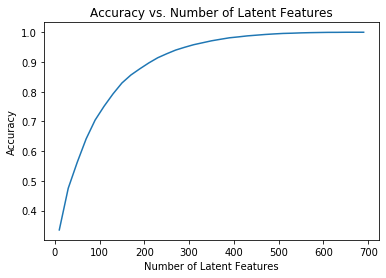

In [498]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data.

In [499]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [513]:
# users in the train/test 
common_id = set(user_item_train.index).intersection(set(test_idx))
len(common_id), len(test_idx)

(20, 682)

In [521]:
# movies in the train/test 
common_item = set(user_item_train.columns).intersection(set(test_arts))
len(common_item), len(test_arts)

(574, 574)

In [508]:
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [510]:
# fit SVD on the user_item_train matrix


In [555]:
# how well we can use the training decomposition to predict on test data
user_item_est_common = user_item_train.loc[common_id, list(common_item)]
user_item_test_common = user_item_test.loc[common_id]

# compute error for each prediction to actual value
diffs = np.subtract(user_item_test_common, user_item_est_common)
    
# total errors and keep track of them
err = np.sum(np.sum(np.abs(diffs)))
sum_errs.append(err)

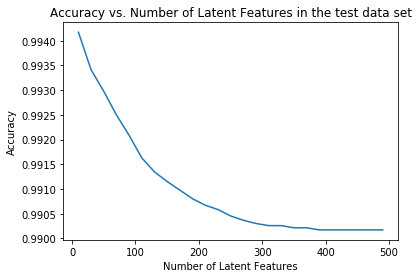

In [568]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

num_latent_feats = np.arange(10,500+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = pd.DataFrame(np.around(np.dot(np.dot(u_new, s_new), vt_new)),
        index   = user_item_train.index, 
        columns =  user_item_train.columns)

    # slice on test data
    user_item_est_common = user_item_est.loc[common_id, list(common_item)]
    user_item_test_common = user_item_test.loc[common_id]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_est_common, user_item_test_common)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features in the test data set');

`6.` Given the circumstances of the results, what we might do to determine if the recommendations we make with any of the above recommendation systems are an improvement to how users currently find articles? 

**We can see if we include more features, the acurracy in the test data set actually decreases. There seems to be a overfittig problem. In online testing, we can conduct a A/B test to see if the click rates improve for the recommmended articles compared to how users currently find articles.**

<a id='conclusions'></a>
### Extras
Using the workbook, you could now save the recommendations for each user, develop a class to make new predictions and update the results, and make a flask app to deploy the results.  

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [569]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0